# **K-Nearest Neighbors method**
K-Nearest Neighbors (or simply KNN) is a classification and regression algorithm based on the compactness hypothesis, which assumes that objects located close to each other in the feature space have similar values of the target variable or belong to the same class.

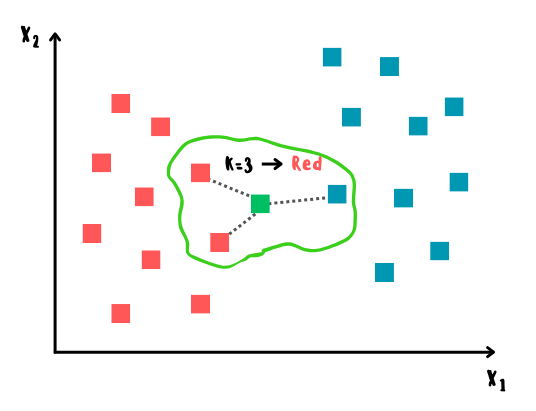

### **The principle of KNN operation**
The algorithm is constructed as follows:
- 1) first, the distance between the test and all training samples is calculated;
- 2) next, k-nearest samples (neighbors) are selected from them, where the number k is set in advance;
- 3) the final prediction among the selected k-nearest samples will be the mode in the case of classification and the arithmetic mean in the case of regression;
- 4) The previous steps are repeated for all test samples.

There are many metrics for calculating the distance between objects, among which the most popular are the following:
- Euclidean distance is the simplest and most generally accepted metric, which is defined as the length of the segment between two objects $a$ and $b$ in a space with $n$ features and is calculated using the formula:

$$d(a, b) = \sqrt{\sum_{i=1}^n (a_i - b_i)^2}$$

- Manhattan distance is a metric that is defined as the sum of the modules of the coordinate differences of two points in the space between two objects $a$ and $b$ with $n$ features and is calculated using the formula:

$$d(a, b) = \sum_{i=1}^n |a_i - b_i|$$

- Cosine distance is a metric that is defined as the angle between two vectors $a$ and $b$ in a space with $n$ features and is calculated using the formula:

$$d(a, b) = 1 - \frac{\sum_{i=1}^n a_i b_i}{\sqrt{\sum_{i=1}^n a_i^2} \sqrt{\sum_{i=1}^n b_i^2}}$$

### **Faster optimizations**
The type of KNN described above is called **Brute-Force** because it uses the brute force method to find the nearest neighbors, which makes it easy to implement, but too slow when working with a large amount of data. To solve this problem, the implementation of scikit-learn provides more advanced methods based on binary trees, which allows you to get a significant increase in performance.

#### **Ball Tree**
BallTree is a tree-like structure based on splitting the original data space into nested hyperspheres, which allows you to more effectively cut off large areas of space in which there are no nearest neighbors for points. In most cases, this algorithm is suitable for data with an arbitrary distance metric.

**Building a Ball Tree consists of the following steps**:
- 1) from a set of points, one is randomly selected and the farthest point is located for it;
- 2) next, all points are divided into spheres (nodes) according to the closest location to two points from step 1;
- 3) then this process is repeated recursively for each sphere until a certain number of points remain in it or a given tree depth is reached.

When searching for the k-nearest neighbors for a new point, the algorithm compares the distance from a given point to the center of each child node and leaves only those in which this distance is less than the radius of the nodes.

To assess the quality of the resulting tree structure and its further optimization, information about intersecting hyperspheres (nodes) will be very useful A and B in the metric M, the distance between which can be determined as follows:

$$d_M(A, B) = \max(0, d_M(c_A, c_{B}) - r_A - r_{B})$$

where $c_A$ and $c_{B}$ are the centers of the spheres, and $r_A$ and $r_{B}$ are their radii.

In this case, optimizing the BallTree taking into account intersecting hyperspheres (nodes) may include the following approaches:
- balancing the tree: since the intersection of hyperspheres may indicate an unbalanced tree, rebalancing its nodes allows to improve search efficiency by minimizing the number of visited nodes;
- choosing the optimal leaf size: in the case of a strong intersection of hyperspheres, increasing the leaf size can reduce the number of nodes, which will also speed up the search;
- node merging: useful for significant intersections, which also reduces their total number and is used in the previous paragraphs;
- choosing the order of traversal: information about the intersection structure can make the order of visited nodes more efficient, starting with the most likely candidates.

It is worth noting that the described optimization methods, give or take, can be applied in a similar way to the algorithm below.

#### **KD-Tree**
KD-Tree (k-dimensional tree) is another tree-like structure, vaguely resembling a BallTree, however, in this case hyperplanes are used to split points instead of hyperspheres, which also makes it possible to effectively leave only those areas of the data space in which the nearest neighbors may be present. Usually, the KD-Tree is more suitable for data with Euclidean or Manhattan distance metric.

**Building a KD-Tree consists of the following steps**:
- 1) one of the coordinates is selected from the set of points (usually alternately for each level of the tree, but it is also possible randomly) and the median is calculated from it;
- 2) next, all points are divided into two nodes (subsets) with respect to the median: those whose value of the selected coordinate is less than or equal to the median, and those with more;
- 3) this process is repeated recursively for each node until a certain number of points remain in it or a given tree depth is reached.

When searching for the nearest neighbors for a new point, the algorithm compares the value of a given point with the median at each node, thus choosing the nearest subspace, which will be a leaf with the nearest neighbors. Going back to the root, the algorithm will compare the points in the current node with the nearest neighbors and update their values if they are closer to the specified point.

It is also worth adding that KNN can be used in the context of unsupervised learning, for example in clustering tasks to calculate distances between features, as in the DBSCAN algorithm, which will be discussed a little later. To do this, there is a special [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) class in scikit-learn.

### **Python implementation from scratch**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.datasets import load_iris, load_diabetes
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [ ]:
class KNearestNeighbors:
    def __init__(self, n_neighbors=5, regression=False):
        self.n_neighbors = n_neighbors
        self.regression = regression

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = X_train, y_train

    def _euclidean_distances(self, x_test_i):
        return np.sqrt(np.sum((self.X_train - x_test_i) ** 2, axis=1))

    def _make_prediction(self, x_test_i):
        distances = self._euclidean_distances(x_test_i)   # distances to all neighbors
        k_nearest_indexes = np.argsort(distances)[:self.n_neighbors]
        targets = self.y_train[k_nearest_indexes]   # k-nearest neighbors target values

        return np.mean(targets) if self.regression else np.bincount(targets).argmax()

    def predict(self, X_test):
        return np.array([self._make_prediction(x) for x in X_test])

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Iris dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset) will be used to train models, where it is necessary to correctly determine the types of flowers based on their characteristics. In the case of regression, the load_linneryd dataset from scikit-learn is used.

In [ ]:
df_path = "/content/drive/MyDrive/iris.csv"
iris = pd.read_csv(df_path)
X1, y1 = iris.iloc[:, :-1], iris.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values, y1.values, test_size=0.3, random_state=0)
print(iris)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


In [ ]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2.values, y2.values, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Models training and evaluation of the obtained results**
KNN showed a good result in the case of classification. It can also be noted that the algorithm is able to build nonlinear decision boundaries, which also allows it to achieve good results with data in which a nonlinear dependence is traced.

However, it is worth paying attention to the case of regression: the low r2-score is due to the small number of nearest neighbors by default. If you increase the number of neighbors to 30, then the r2-score will increase by more than 2 times, which indicates the importance of selecting the optimal number of nearest neighbors.

**KNN classifier**

In [ ]:
knn_clf = KNearestNeighbors()
knn_clf.fit(X1_train, y1_train)
knn_clf_pred_res = knn_clf.predict(X1_test)
knn_clf_accuracy = accuracy_score(y1_test, knn_clf_pred_res)

print(f'KNN classifier accuracy: {knn_clf_accuracy:}')
print(knn_clf_pred_res)

KNN classifier accuracy: 0.9777777777777777
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0]


**KNN regressor**

In [ ]:
knn_reg = KNearestNeighbors(regression=True)
knn_reg.fit(X2_train, y2_train)
knn_reg_pred_res = knn_reg.predict(X2_test)
knn_reg_r2 = r2_score(y2_test, knn_reg_pred_res)

print(f'KNN regressor R2 score: {knn_reg_r2}')
print(knn_reg_pred_res)

KNN regressor R2 score: 0.18912404854026388
[253.6 188.6 183.2 138.4 177.8 189.6 111.8 229.  178.  266.8 147.6 193.8
 136.4  55.6 297.4  73.6  97.2  83.8 130.8 214.4 173.6 115.2 167.4 101.
 186.8 175.6  97.2  75.  172.4 144.2 205.4  63.8 161.6 190.8 110.2 159.2
 199.4 141.2 121.4 140.8 155.6 173.8 140.6 175.6 134.2  84.6 110.4 127.2
 107.4 209.2 130.2  78.2 183.6 105.  227.4 160.4 155.  104.6 119.2 175.8
 159.8 141.6 150.4 100.2 279.2 128.4  91.2 269.2 183.2  88.4 118.  151.6
  74.8  97.8 126.2 140.4 127.4 223.6 236.6 191.2 111.6 219.8  69.6 169.4
  87.6  92.6 112.  145.8 117.  153.2 115.2  92.8  67.6 172.   92.4 106.6
 208.4 173.8 113.2 104.4 141.6 128.2 226.   87.  247.6 147.6 223.6 217.2
 149.   72.6 182. ]


**KNN classifier (scikit-learn)**

sk KNN classifier accuracy: 0.9777777777777777
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0]


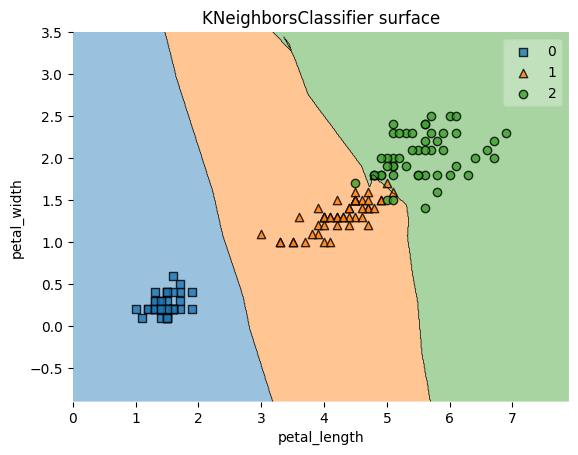

In [ ]:
sk_knn_clf = KNeighborsClassifier()
sk_knn_clf.fit(X1_train, y1_train)
sk_knn_clf_pred_res = sk_knn_clf.predict(X1_test)
sk_knn_clf_accuracy = accuracy_score(y1_test, sk_knn_clf_pred_res)

print(f'sk KNN classifier accuracy: {sk_knn_clf_accuracy:}')
print(sk_knn_clf_pred_res)

feature_indexes = [2, 3]
title1 = 'KNeighborsClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_knn_clf, feature_indexes, title1)

**KNN regressor (scikit-learn)**

In [ ]:
sk_knn_reg = KNeighborsRegressor()
sk_knn_reg.fit(X2_train, y2_train)
sk_knn_reg_pred_res = sk_knn_reg.predict(X2_test)
sk_knn_reg_r2 = r2_score(y2_test, sk_knn_reg_pred_res)

print(f'sk KNN regressor R2 score: {sk_knn_reg_r2}')
print(sk_knn_reg_pred_res)

sk KNN regressor R2 score: 0.18912404854026388
[253.6 188.6 183.2 138.4 177.8 189.6 111.8 229.  178.  266.8 147.6 193.8
 136.4  55.6 297.4  73.6  97.2  83.8 130.8 214.4 173.6 115.2 167.4 101.
 186.8 175.6  97.2  75.  172.4 144.2 205.4  63.8 161.6 190.8 110.2 159.2
 199.4 141.2 121.4 140.8 155.6 173.8 140.6 175.6 134.2  84.6 110.4 127.2
 107.4 209.2 130.2  78.2 183.6 105.  227.4 160.4 155.  104.6 119.2 175.8
 159.8 141.6 150.4 100.2 279.2 128.4  91.2 269.2 183.2  88.4 118.  151.6
  74.8  97.8 126.2 140.4 127.4 223.6 236.6 191.2 111.6 219.8  69.6 169.4
  87.6  92.6 112.  145.8 117.  153.2 115.2  92.8  67.6 172.   92.4 106.6
 208.4 173.8 113.2 104.4 141.6 128.2 226.   87.  247.6 147.6 223.6 217.2
 149.   72.6 182. ]


### **Pros and cons of KNN**
Pros:
- easy to implement and interpret;
- it is used in many tasks, especially in recommendation systems;
- high predictions accuracy with the correct selection of k and distance metrics.

Cons:
- high memory consumption and low speed due to the storage and calculation of distances between all training and test samples (meaning KNN in its pure form);
- sensitivity to outliers and noise, as well as to unbalanced classes in the data;
- with a large number of features, the problem of matching the metric and semantic proximity of objects may arise, which is solved by representation learning (numerical description of objects).

### **Additional sources**
Papers:
- «Brute-Force k-Nearest Neighbors Search on the GPU», Shengren Li and Nina Amenta;
- «Unsupervised Space Partitioning for Nearest Neighbor Search», Abrar Fahim, Mohammed Eunus Ali and Muhammad Aamir Cheema;
- «Five Balltree Construction Algorithms», Omohundro, S.M.;
- «Ball*-tree: Efficient spatial indexing for constrained nearest-neighbor search in metric
spaces», Mohamad Dolatshah, Ali Hadian and Behrouz Minaei-Bidgoli;
- «Developments in KD Tree and KNN Searches», Vijay R. Tiwari.

Documentation:
- [KNN description](https://scikit-learn.org/stable/modules/neighbors.html#classification);
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html);
- [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
- [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html).

Video: [one](https://www.youtube.com/watch?v=gcM3QfVHhOo), [two](https://www.youtube.com/watch?v=09mb78oiPkA), [three](https://www.youtube.com/watch?v=fy40y3UFkNE).

